<div style="color:#00ADB5;
               display:fill;
               border-radius:5px;
               background-color:#393E46;
               font-size: 30px;
               font-family:sans-serif;
               letter-spacing:0.5px">
            <p style="padding: 10px;
                  color:white;">
                <b> Digit Recognizer: ANN</b>
            </p>
    </div>

## Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
# from torch ? for loss # we will need cross entropy loss since multiple classes are involved

## Data Preprocessing

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train[['label']])
encoded_cols = list(encoder.get_feature_names_out(['label']))
train[encoded_cols] = encoder.transform(train[['label']])

train.drop(labels=['label'], inplace=True, axis=1)

X_train = train.drop(labels=encoded_cols, axis=1).values
Y_train = train[encoded_cols].values
X_test = test.values

X_train = X_train/255
X_test  = X_test/255

## Loading Data

In [3]:
input_tensor = torch.tensor(X_train, dtype=torch.float32)
output_tensor = torch.tensor(Y_train, dtype=torch.float32)
dataset = TensorDataset(input_tensor, output_tensor)
train_size = round(len(dataset)*0.8)
val_size = len(dataset)-train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size = 100 # can change later
train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle=True, num_workers=4 ) # for number of cores at work
val_loader  = DataLoader(val_dataset, batch_size = batch_size)
# Since the iteration over the batches is done for optimizing weights more efficiently

## Architecture

In [4]:
# Model Architecture
class ANN(nn.Module):
    def __init__(self, input_features, n_class):
        super(ANN, self).__init__()
        self.l1 = nn.Linear(input_features, 256)
        self.l2 = nn.Linear(256, 64)
#         self.l3 = nn.Linear(128, 64)
#         self.l4 = nn.Linear(64, 32)
        self.l5 = nn.Linear(64, n_class)
    
    def forward(self, x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
#         x = torch.relu(self.l3(x))
#         x = torch.relu(self.l4(x))
        x = self.l5(x)
        return x

# Pushing Model to GPU if it is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANN(input_features=784, n_class = 10).to(device)

## Training and Evaluation

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

true_num_epochs = 0
num_epochs = 100
training_loss = []
validation_loss = []
training_acc = []
validation_acc = []

for i in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        true_targets = torch.argmax(targets, dim=1)
        acc = accuracy_score(true_targets.detach().cpu().numpy(), predicted_classes.detach().cpu().numpy())
        train_acc += acc
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

            probabilities = torch.softmax(outputs, dim=1)
            predicted_classes = torch.argmax(probabilities, dim=1)
            true_targets = torch.argmax(targets, dim=1)
            acc = accuracy_score(true_targets.detach().cpu().numpy(), predicted_classes.detach().cpu().numpy())
            val_acc += acc

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader)
    validation_loss.append(val_loss)
    training_loss.append(train_loss)
    training_acc.append(train_acc)
    validation_acc.append(val_acc)
    true_num_epochs += 1

    print(f"Epoch: {i + 1}/{num_epochs}, Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}, Training Acc: {train_acc:.5f}, Validation Acc: {val_acc:.5f}")

torch.save(model.state_dict(), 'ANN.pth')


Epoch: 1/100, Training Loss: 0.45800, Validation Loss: 0.23396, Training Acc: 0.87095, Validation Acc: 0.93036
Epoch: 2/100, Training Loss: 0.17555, Validation Loss: 0.15138, Training Acc: 0.94902, Validation Acc: 0.95452
Epoch: 3/100, Training Loss: 0.11952, Validation Loss: 0.12363, Training Acc: 0.96491, Validation Acc: 0.96500
Epoch: 4/100, Training Loss: 0.08800, Validation Loss: 0.11700, Training Acc: 0.97268, Validation Acc: 0.96667
Epoch: 5/100, Training Loss: 0.06623, Validation Loss: 0.10301, Training Acc: 0.97923, Validation Acc: 0.96881
Epoch: 6/100, Training Loss: 0.05013, Validation Loss: 0.10720, Training Acc: 0.98473, Validation Acc: 0.96810
Epoch: 7/100, Training Loss: 0.03956, Validation Loss: 0.10982, Training Acc: 0.98777, Validation Acc: 0.96857
Epoch: 8/100, Training Loss: 0.03048, Validation Loss: 0.10818, Training Acc: 0.99039, Validation Acc: 0.97167
Epoch: 9/100, Training Loss: 0.02289, Validation Loss: 0.11052, Training Acc: 0.99304, Validation Acc: 0.97143
E

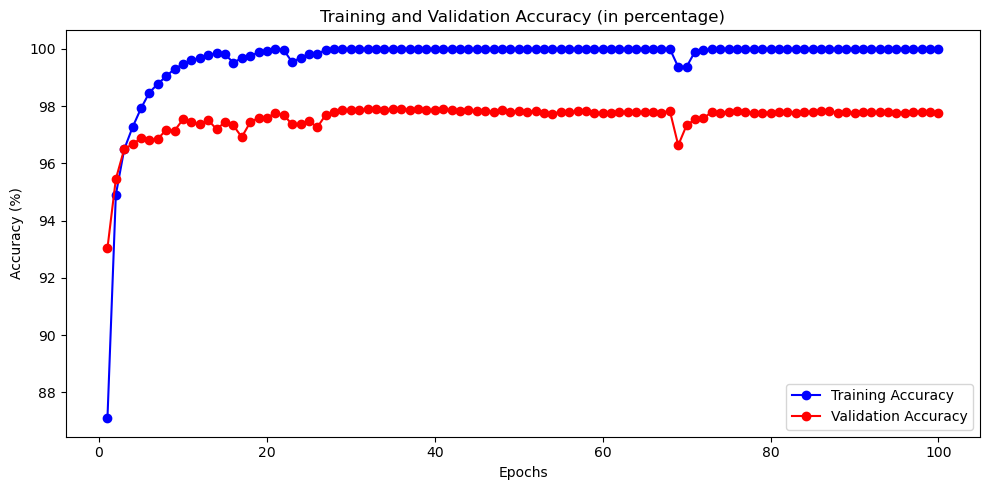

In [6]:
epochs = range(1, int(true_num_epochs) + 1)

plt.figure(figsize=(10, 5))

plt.plot(epochs, np.array(training_acc)*100, 'b-o', label='Training Accuracy')
plt.plot(epochs, np.array(validation_acc)*100, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (in percentage)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

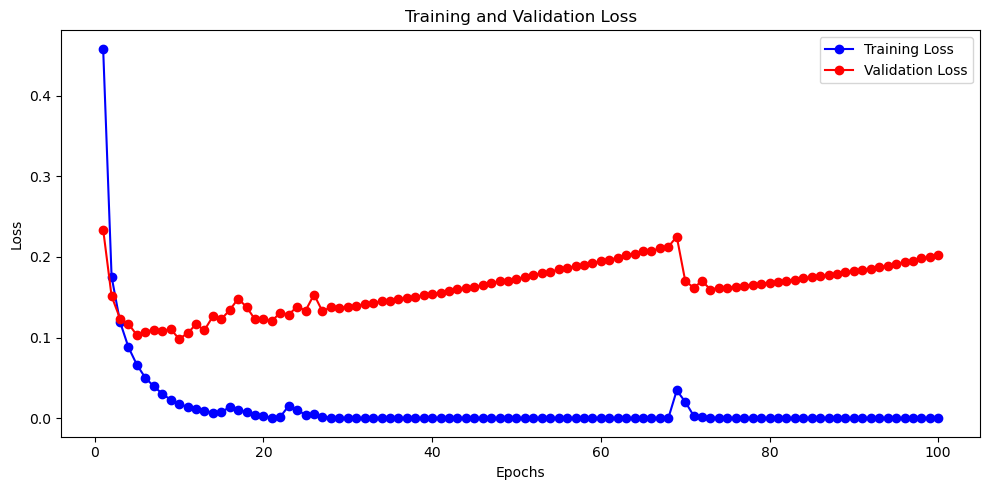

In [7]:
epochs = range(1, int(true_num_epochs) + 1)

plt.figure(figsize=(10, 5))

plt.plot(epochs, training_loss, 'b-o', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()